## Import Library dan Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Melakukan loading dataset

In [2]:
df = pd.read_csv('dataset.csv')

df

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000
...,...,...,...,...,...,...,...
6553,2025-02-10,133.570007,133.570007,135.000000,129.960007,130.089996,216989100
6554,2025-02-11,132.800003,132.800003,134.479996,131.020004,132.580002,178902400
6555,2025-02-12,131.139999,131.139999,132.240005,129.080002,130.020004,160278600
6556,2025-02-13,135.289993,135.289993,136.500000,131.169998,131.559998,197430000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6558 entries, 0 to 6557
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6558 non-null   object 
 1   Adj Close  6558 non-null   float64
 2   Close      6558 non-null   float64
 3   High       6558 non-null   float64
 4   Low        6558 non-null   float64
 5   Open       6558 non-null   float64
 6   Volume     6558 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 358.8+ KB


In [4]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03
mean,8.768532,8.795447,8.956567,8.618315,8.795850,5.991103e+08
std,23.907205,23.904882,24.349618,23.419200,23.922708,4.307236e+08
min,0.031286,0.034115,0.035547,0.033333,0.034896,1.968000e+07
25%,0.257739,0.281042,0.288511,0.273354,0.280810,3.384780e+08
50%,0.437176,0.466083,0.472875,0.459250,0.466584,5.002635e+08
75%,4.597059,4.644625,4.724000,4.588750,4.632437,7.307002e+08
max,149.429993,149.429993,153.130005,147.820007,153.029999,9.230856e+09


Mengetahui jumlah data yang memiliki missing value

In [5]:
print("Jumlah data bernilai NULL: ")
df.isnull().sum()

Jumlah data bernilai NULL: 


Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Mengetahui jumlah data yang terduplikasi

In [6]:
duplicate = df.duplicated().sum()
print(f"Jumlah data terduplikasi: {duplicate}")

Jumlah data terduplikasi: 0


Mengetahui banyaknya bairs data dan kolom

In [7]:
df.shape

(6558, 7)

## Visualisasi dan Eksplorasi Data Analisis Harga Saham NVIDIA
Visualisasi tren harga saham dari tahun 1999-2025

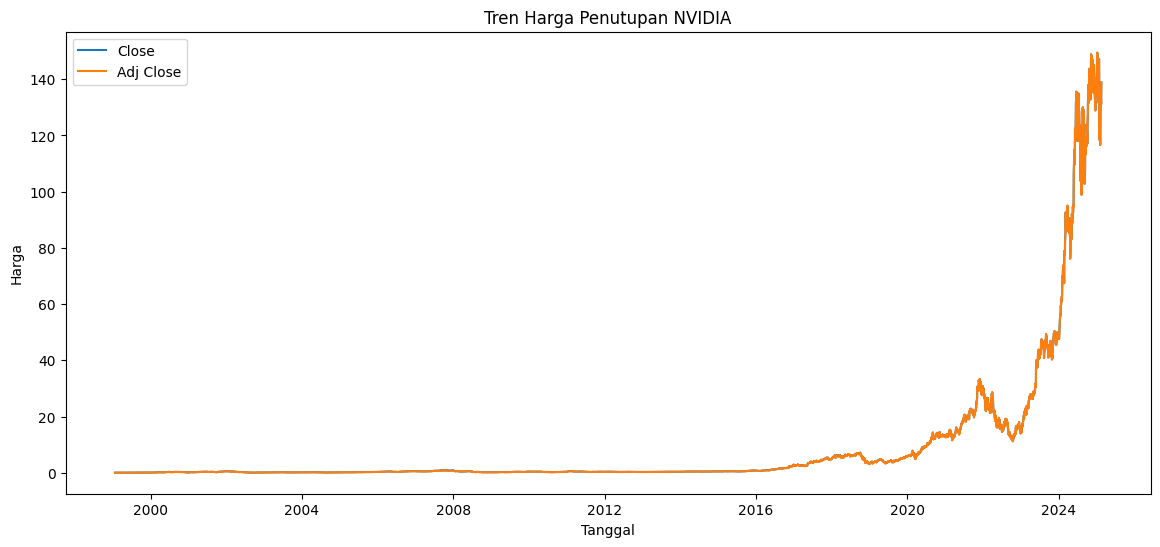

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close')
plt.plot(df['Adj Close'], label='Adj Close')
plt.legend()
plt.title('Tren Harga Penutupan NVIDIA')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.show()

Distribusi volume perdagangan (jumlah perdagangan saham)

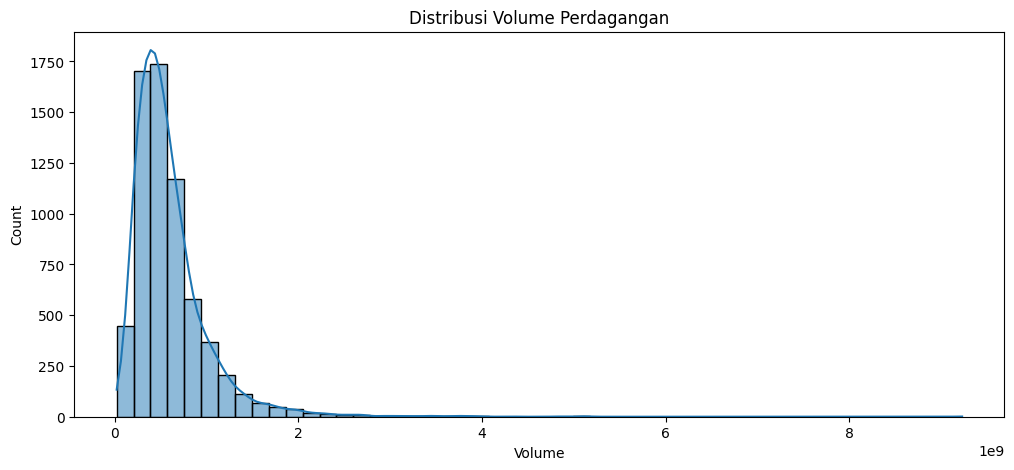

In [9]:
plt.figure(figsize=(12,5))
sns.histplot(df['Volume'], bins=50, kde=True)
plt.title('Distribusi Volume Perdagangan')
plt.show()

Heatmap korelasi antar fitur

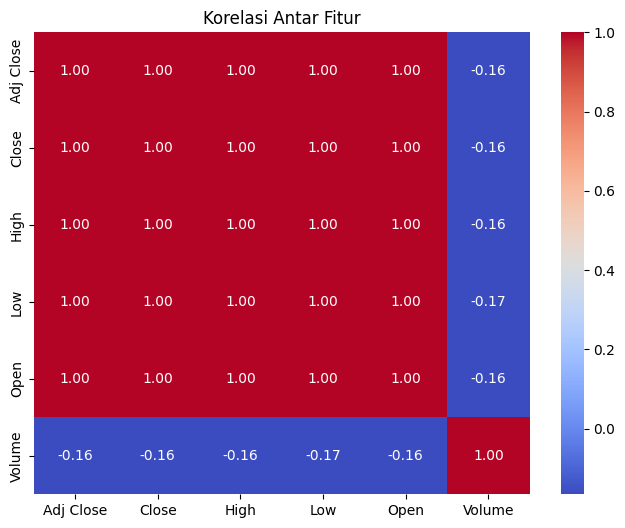

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

Melihat tren rata-rata harga per bulan

C:\Users\nikol\AppData\Local\Temp\ipykernel_22948\358588143.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['Close'].resample('M').mean()


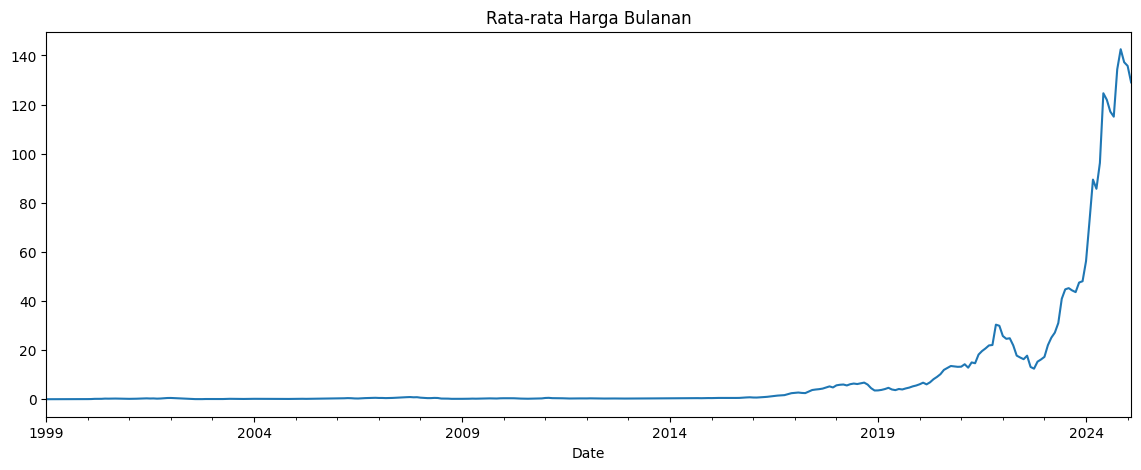

In [11]:
monthly = df['Close'].resample('M').mean()
plt.figure(figsize=(14,5))
monthly.plot()
plt.title('Rata-rata Harga Bulanan')
plt.show()

Melihat outliers pada data

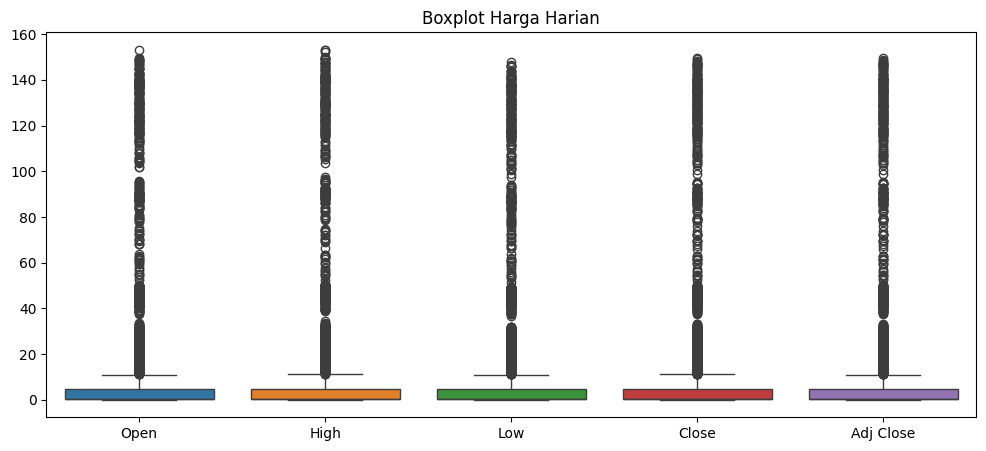

In [12]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df[['Open','High','Low','Close','Adj Close']])
plt.title('Boxplot Harga Harian')
plt.show()

## Data Preprocessing

Melakukan penghapusan outliers

In [13]:
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = df_clean.shape[0]
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        after = df_clean.shape[0]
        print(f"{col}: Dihapus {before - after} outlier")
    return df_clean

cols_outlier = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

df = remove_outliers_iqr(df, cols_outlier)

print("Setelah penghapusan outliers:", df.shape)

Open: Dihapus 1136 outlier
High: Dihapus 1027 outlier
Low: Dihapus 111 outlier
Close: Dihapus 29 outlier
Adj Close: Dihapus 32 outlier
Volume: Dihapus 195 outlier
Setelah penghapusan outliers: (4028, 6)


Melakukan standarisasi pada data

In [14]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()

features = df[['Open','High','Low','Close','Volume']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

y = df['Adj Close'].values.reshape(-1, 1)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

## Split Data dan Pemodelan

Modelling menggunakan LSTM yang diawali dengan pembuatan data sekuensial

In [15]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=30)

split_index = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

c:\Users\nikol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0840 - mae: 0.2015 - val_loss: 7.4743e-04 - val_mae: 0.0223
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0655 - val_loss: 2.9456e-04 - val_mae: 0.0135
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - mae: 0.0496 - val_loss: 2.7804e-04 - val_mae: 0.0133
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mae: 0.0450 - val_loss: 2.4304e-04 - val_mae: 0.0123
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mae: 0.0377 - val_loss: 2.1480e-04 - val_mae: 0.0115
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mae: 0.0344 - val_loss: 2.0674e-04 - val_mae: 0.0115
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 1.8636e-04 - val_mae: 0.0106
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 2.1344e-04 - val_mae: 0.0115
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━

## Evaluasi Model

In [16]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Evaluasi LSTM:")
print(f"MAE   : {mae:.3f}")
print(f"RMSE  : {rmse:.3f}")
print(f"R^2   : {r2:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluasi LSTM:
MAE   : 0.011
RMSE  : 0.017
R^2   : 0.981


## Prediksi dan Visualisasi

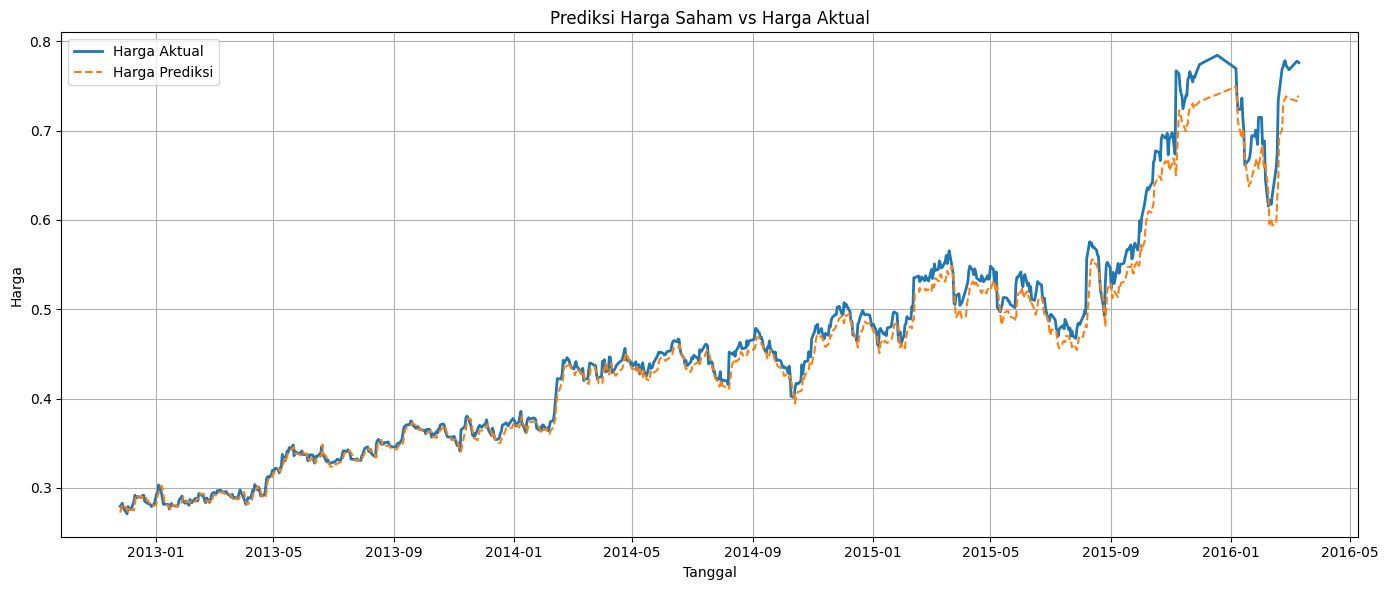

In [17]:
hasil_prediksi = pd.DataFrame({
    'Tanggal': df.index[-len(y_test):],
    'Harga Aktual': y_true.flatten(),
    'Harga Prediksi': y_pred.flatten()
})
hasil_prediksi.set_index('Tanggal', inplace=True)

plt.figure(figsize=(14,6))
plt.plot(hasil_prediksi['Harga Aktual'], label='Harga Aktual', linewidth=2)
plt.plot(hasil_prediksi['Harga Prediksi'], label='Harga Prediksi', linestyle='--')
plt.title('Prediksi Harga Saham vs Harga Aktual')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()